In [14]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from statistics import mean
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
import missingpy
from missingpy import MissForest
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None

In [2]:
#load clinical
clinical_data = pd.read_csv('clinical_data.csv', index_col=[0])
clinical_data = clinical_data.rename(columns={'Python_ID_Index_falsepositive': 'StudyID_x'})

clinical_data = clinical_data[['Age', 'Sex', 'AtrialArrhythmia', 'LowLVEF', 'ReducedLVEF', 'NormalLVEF', 
              'OHCA', 'ICM', 'NICM', 'HCM', 'DCM', 'PAS', 'PCI', 'CABG', 'MyocardialInfarction', 
              'VF', 'NSVT', 'SustVT', 'CVA', 'COPD', 'DiabetesMellitus', 'BMI', 'PAF', 'QRS_Duration', 
              'Hypertension', 'CHD', 'Sodium', 'Potassium', 'Kreatinine', 'Dyslipedaemia', 'VR', 'DR', 'ARB', 'Diuretica',
              'CRTD', 'SICD', 'Vitamine_K', 'Antiaritmica_soort#Sotalol', 'ImplantationDate', 'Antiaritmica_soort#Digoxine',
              'Antiaritmica_soort#Amiodarone', 'Betablokker', 'NOAC', 'Aldosteronremmer', 'Implantation_indication',
                'MonthsTillAppropriateTherapy', 'AppropriateTherapy', 'Python_ID_Index', 'StudyID_x']]

clinical_data['MonthsTillAppropriateTherapy'] = clinical_data['MonthsTillAppropriateTherapy'] * 30

#Rename columns
clinical_data = clinical_data.rename(columns={'Python_ID_Index': 'PatientID', 'AppropriateTherapy' : 'Event', 
                              'MonthsTillAppropriateTherapy' : 'Days_until_therapy',
                             'ImplantationDate' : 'Date_ICD_implantatie'})

#Convert to date-time
clinical_data['Date_ICD_implantatie'] = pd.to_datetime(clinical_data['Date_ICD_implantatie'], format='%Y-%m-%d')

In [9]:
print('mean follow-up in months', (clinical_data['Days_until_therapy'] / 30) .mean())
print('std', (clinical_data['Days_until_therapy'] / 30).std())
print(clinical_data.shape)

mean follow-up in months 43.912723231412116
std 35.84571961764746
(2942, 49)


In [10]:
df = clinical_data

#Drop columns
var_drop = ['Date_ICD_implantatie', 'StudyID_x']
df_dateim = df
df = df.drop(var_drop, axis=1)

#Select categorical variables
var_bin = ['Sex', 'AtrialArrhythmia', 'LowLVEF', 'ReducedLVEF', 'OHCA', 'ICM', 'NICM', 'HCM', 'DCM', 'PAS',
'PCI', 'CABG', 'MyocardialInfarction', 'VF', 'NSVT','SustVT', 'CVA','COPD', 'DiabetesMellitus', 'PAF', 'Hypertension', 
'CHD', 'Dyslipedaemia', 'VR', 'DR', 'CRTD', 'SICD', 'Vitamine_K', 'Antiaritmica_soort#Sotalol', 'Antiaritmica_soort#Digoxine', 
'Antiaritmica_soort#Amiodarone', 'Betablokker', 'NOAC', 'Aldosteronremmer', 'ARB', 'Diuretica']
df[var_bin] = df[var_bin].astype('category')
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('category').columns)]
df = df.replace(-99.0, np.NaN)

#Make instance of MissForest
imputer = MissForest()

#Impute missing values
df_imp = imputer.fit_transform(df, cat_vars=catColumnsPos)
tsfresh_clin_bl = pd.DataFrame(df_imp, columns=df.columns)
tsfresh_clin_bl['Date_ICD_implantatie'] = df_dateim['Date_ICD_implantatie']
tsfresh_clin_bl['StudyID_x'] = df_dateim['StudyID_x']

clinical_data_imputed = tsfresh_clin_bl

clinical_data_imputed[tsfresh_clin_bl.PatientID == 2]
clinical_data_imputed.shape
#clinical_data_imputed.to_csv('clinical_data_imputed.csv')
clinical_data_imputed = pd.read_csv('clinical_data_imputed.csv', index_col=[0])

In [11]:
clinical_data_imputed = pd.read_csv('clinical_data_imputed.csv', index_col=[0])

# Assuming 'tru' is a DataFrame with the necessary columns
conditions = [clinical_data_imputed['VF'] == 1, clinical_data_imputed['SustVT'] == 1, clinical_data_imputed['NSVT'] == 1]
choices = [1, 2, 3]
clinical_data_imputed['VA'] = np.select(conditions, choices, default=0)

conditions = [clinical_data_imputed['VR'] == 1, clinical_data_imputed['DR'] == 1, clinical_data_imputed['CRTD'] == 1, clinical_data_imputed['SICD'] == 1]
choices = [1, 2, 3, 4]
clinical_data_imputed['Device'] = np.select(conditions, choices, default=0)

conditions = [clinical_data_imputed['ICM'] == 1,clinical_data_imputed['DCM'] == 1,clinical_data_imputed['HCM'] == 1,clinical_data_imputed['NICM'] == 1,clinical_data_imputed['PAS'] == 1]
choices = [1, 2, 3, 4, 5]
clinical_data_imputed['CMP'] = np.select(conditions, choices, default=0)

conditions = [clinical_data_imputed['NormalLVEF'] == 1, clinical_data_imputed['ReducedLVEF'] == 1, clinical_data_imputed['LowLVEF'] == 1]
choices = [1, 2, 3]
clinical_data_imputed['LVEF'] = np.select(conditions, choices, default=0)


#### from tableone import TableOne, load_dataset
import numpy as np
from tableone import TableOne, load_dataset
columns = ['Age', 'Sex', 'Implantation_indication', 'LVEF', 'OHCA',  'VA', 'VF',
           'CMP', 'PCI', 'CABG', 'MyocardialInfarction', 'AtrialArrhythmia', 'CVA', 'COPD', 
           'DiabetesMellitus', 'BMI', 'PAF', 'Hypertension', 'CHD', 'Sodium', 'Potassium', 'Kreatinine', 'Vitamine_K', 
           'Antiaritmica_soort#Sotalol', 'Antiaritmica_soort#Digoxine', 'Antiaritmica_soort#Amiodarone', 
           'Betablokker', 'NOAC', 'Aldosteronremmer', 'Diuretica', 'ARB',
           'Device']
categorical =  ['Sex', 'AtrialArrhythmia', 'Implantation_indication', 'LVEF',
                'OHCA', 'PCI', 'CABG', 'MyocardialInfarction','Vitamine_K',  'Diuretica', 
           'Antiaritmica_soort#Sotalol', 'Antiaritmica_soort#Digoxine', 'Antiaritmica_soort#Amiodarone', 
           'Betablokker', 'NOAC', 'Aldosteronremmer', 'VA', 'CVA', 'COPD', 'DiabetesMellitus', 'PAF', 'ARB', 
                'Hypertension', 'CHD',  'Device', 'CMP']
mytable = TableOne(clinical_data_imputed, categorical=categorical, columns = columns, groupby="StudyID_x", pval=True)
print(mytable.tabulate(tablefmt="github"))
#mytable.to_excel('Baseline table.xlsx')

|                                      |     | Missing   | Overall      | 0            | 1           | P-Value   |
|--------------------------------------|-----|-----------|--------------|--------------|-------------|-----------|
| n                                    |     |           | 2942         | 1144         | 1798        |           |
| Age, mean (SD)                       |     | 0         | 61.7 (13.9)  | 64.3 (12.0)  | 60.1 (14.8) | <0.001    |
| Sex, n (%)                           | 0.0 | 0         | 749 (25.5)   | 266 (23.3)   | 483 (26.9)  | 0.032     |
|                                      | 1.0 |           | 2193 (74.5)  | 878 (76.7)   | 1315 (73.1) |           |
| Implantation_indication, n (%)       | 1.0 | 0         | 1779 (60.5)  | 712 (62.2)   | 1067 (59.3) | 0.127     |
|                                      | 2.0 |           | 1163 (39.5)  | 432 (37.8)   | 731 (40.7)  |           |
| LVEF, n (%)                          | 1   | 0         | 671 (22.8)   | 146 (1

In [12]:

#Split type of therapy
clinical_data = pd.read_csv('clinical_data.csv', index_col=[0])

clinical_data['Shock'] = (((clinical_data['AppropriateTherapyType'] == 1) | 
                              (clinical_data['AppropriateTherapyType'] > 3)) & 
                             (clinical_data['MonthsTillAppropriateTherapy'] <= 321206))
clinical_data['Shock'] = (((clinical_data['AppropriateTherapyType'] == 1) | (clinical_data['AppropriateTherapyType'] > 3)) & (clinical_data['MonthsTillAppropriateTherapy'] <= 113006))
clinical_data['Shock/ATP'] = ((clinical_data['AppropriateTherapyType'] == 3) & (clinical_data['MonthsTillAppropriateTherapy'] <= 131006))
clinical_data['Shock/ATP'] = ((clinical_data['AppropriateTherapyType'] == 2) & (clinical_data['MonthsTillAppropriateTherapy'] <= 113006))
clinical_data['ATP'] = ((clinical_data['AppropriateTherapyType'] == 2) & (clinical_data['MonthsTillAppropriateTherapy'] <= 223600))
clinical_data['ATP'] = ((clinical_data['AppropriateTherapyType'] == 3) & (clinical_data['MonthsTillAppropriateTherapy'] <= 123006))
print('done')
import numpy as np

clinical_data['AppropriateTherapyType'] = clinical_data['AppropriateTherapyType'].replace(np.NaN, 0)
clinical_data['AppropriateTherapyType'][clinical_data['AppropriateTherapyType'] >3.0 ] = 1

clinical_data['AppropriateTherapyType'][clinical_data['AppropriateTherapyType'] >0 ] = 1

from tableone import TableOne, load_dataset
columns = ['AppropriateTherapyType',  'Mortality', 'Shock', 'Shock/ATP', 'ATP', 'Python_ID_Index_falsepositive']
categorical =  ['AppropriateTherapyType',  'Mortality', 'Shock', 'Shock/ATP', 'ATP', 'Python_ID_Index_falsepositive']
mytable = TableOne(clinical_data, categorical=categorical, columns = columns, groupby = 'Python_ID_Index_falsepositive', pval=True)
print(mytable.tabulate(tablefmt="github"))

done
|                                      |       | Missing   | Overall     | 0            | 1            | P-Value   |
|--------------------------------------|-------|-----------|-------------|--------------|--------------|-----------|
| n                                    |       |           | 2942        | 1144         | 1798         |           |
| AppropriateTherapyType, n (%)        | 0.0   | 0         | 2102 (71.4) | 830 (72.6)   | 1272 (70.7)  | 0.310     |
|                                      | 1.0   |           | 840 (28.6)  | 314 (27.4)   | 526 (29.3)   |           |
| Mortality, n (%)                     | 0     | 0         | 2311 (78.6) | 868 (75.9)   | 1443 (80.3)  | 0.005     |
|                                      | 1     |           | 631 (21.4)  | 276 (24.1)   | 355 (19.7)   |           |
| Shock, n (%)                         | False | 0         | 2501 (85.0) | 979 (85.6)   | 1522 (84.6)  | 0.526     |
|                                      | True  |           

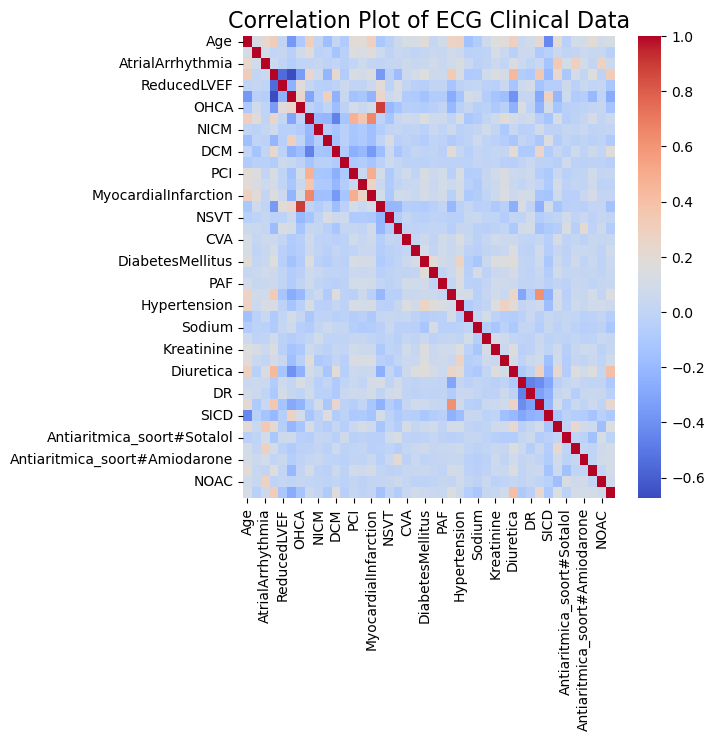

['NormalLVEF', 'MyocardialInfarction', 'VF', 'CRTD']


In [15]:
clinical_data_imputed = pd.read_csv('clinical_data_imputed.csv', index_col=[0])

clin = clinical_data_imputed[['Age', 'Sex', 'AtrialArrhythmia', 'LowLVEF', 'ReducedLVEF', 'NormalLVEF', 'OHCA', 
                 'ICM', 'NICM', 'HCM', 'DCM', 'PAS', 'PCI', 'CABG', 'MyocardialInfarction', 
                 'VF', 'NSVT', 'SustVT', 'CVA', 'COPD', 'DiabetesMellitus', 'BMI', 'PAF', 'QRS_Duration', 
                 'Hypertension', 'CHD', 'Sodium', 'Potassium', 'Kreatinine', 'Dyslipedaemia', 'Diuretica',
                 'VR', 'DR', 'CRTD', 'SICD', 'Vitamine_K', 'Antiaritmica_soort#Sotalol',
                 'Antiaritmica_soort#Digoxine', 'Antiaritmica_soort#Amiodarone', 'Betablokker', 'NOAC', 'Aldosteronremmer']]
def drop_input_corr_columns(x_features, corr_fac = 0.6):
    import numpy as np
    # Create correlation matrix
    corr_matrix = x_features.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.8
    to_drop = [column for column in upper.columns if any(upper[column] > corr_fac)]
    # Drop features 
    x_features_no_colnr = x_features.drop(columns = to_drop) 
    return x_features_no_colnr, to_drop


import seaborn as sns
# calculate the correlation matrix
corr = clin.corr()

# plot the correlation matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Plot of ECG Clinical Data', fontsize=16)
plt.show()

uncor, dropped = drop_input_corr_columns(clin)
print(dropped)

In [43]:
#Get the ECG features
import pandas as pd
#ecg_timevarying = pd.read_csv('ecg_timevarying_latent.csv', index_col=[0])
ecg_timevarying = pd.read_csv('ecg_timevarying_latent_32.csv', index_col=[0])

ecg_timevarying = ecg_timevarying[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 
                                   '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
                                   '28', '29', '30', '31', '1st degree AV block', 'RBBB',
                                   'LBBB', 'SB', 'AF', 'ST', 'Python_ID_Index', 'StudyDate', 'SeriesInstanceUID']]

clinical_data = pd.read_csv('clinical_data.csv', index_col=[0])
blecgdate = clinical_data[['Python_ID_Index']]

#Merge clinical data with ECGs at baseline
baseline_ecg = pd.merge(ecg_timevarying, blecgdate, on='Python_ID_Index', how='left')

C:\Users\mzkolk\AppData\Local\Temp\ipykernel_30536\319661965.py:4: DtypeWarning: Columns (7,12,33,34,38,40,44,97) have mixed types. Specify dtype option on import or set low_memory=False.
  ecg_timevarying = pd.read_csv('ecg_timevarying_latent_32.csv', index_col=[0])


In [50]:
ecg_timevarying['Python_ID_Index'].nunique()
baseline_ecg['Python_ID_Index'].nunique()

2942

In [51]:
from datetime import datetime
import pickle

#Read clinical data
clinical_data = pd.read_csv('clinical_data.csv', index_col=[0])
clinical = clinical_data[['Python_ID_Index', 'MonthsTillAppropriateTherapy', 'AppropriateTherapy']]

final = pd.merge(baseline_ecg, clinical , on='Python_ID_Index', how='left')

#Convet to datetime-format
final['StudyDate'] = pd.to_datetime(final['StudyDate'])
final['MonthsTillAppropriateTherapy'] = final['MonthsTillAppropriateTherapy'] * 30
df_time_varying = final.rename(columns={'Python_ID_Index': 'PatientID', 'StudyDate_x' : 'StudyDate'})
df_time_varying['StudyDate'] = pd.to_datetime(df_time_varying['StudyDate'], format='%Y-%m-%d')

#Select rows with no missing study date
df_time_varying = df_time_varying[df_time_varying['StudyDate'].notna()]

df_time_varying.to_csv('time_varying_AE_32.csv')

# 1. Dataprocessing: make into start-stop


In [52]:
from lifelines.utils import add_covariate_to_timeline
from lifelines.utils import to_long_format

clinical_data_imputed = pd.read_csv('clinical_data_imputed.csv', index_col=[0])

clinical_data_imputed['PatientID'] = clinical_data_imputed['PatientID'].astype(float)
df_time_varying['PatientID'] = df_time_varying['PatientID'].astype(float)

start_stop =  pd.merge(df_time_varying, clinical_data_imputed[['Date_ICD_implantatie', 'PatientID']], on='PatientID')

start_stop['StudyDate'] = pd.to_datetime(start_stop['StudyDate'])
start_stop['Date_ICD_implantatie'] = pd.to_datetime(start_stop['Date_ICD_implantatie'])


# calculate time difference in days
time_diff = (start_stop['StudyDate'] - start_stop['Date_ICD_implantatie']).dt.days

# create new "time" column with time difference values
start_stop['time'] = time_diff

# Create a boolean mask for rows where days_diff is greater than or equal to 0 or where there are no duplicates in PatientID
mask = (start_stop['time'] >= 0) | (~start_stop.duplicated(subset='PatientID', keep='first'))

# Apply the mask to the DataFrame to keep only the desired rows
start_stop_masked = start_stop[mask]

base_df = to_long_format(clinical_data_imputed, duration_col="Days_until_therapy")
base_df[['PatientID', 'start', 'stop', 'Event']]

df = add_covariate_to_timeline(base_df, start_stop_masked, duration_col="time", id_col="PatientID", event_col="Event")
df = df.set_index('PatientID')

# group by patient ID and fill missing values with the available values for that patient
df = df.groupby('PatientID').fillna(method='ffill').fillna(method='bfill')

# reset the index of the dataframe back to the default integer index
df = df.reset_index()

df.to_csv('Lifeline_AT_AE_32.csv')

In [53]:
df =  pd.read_csv('Lifeline_AT_AE_32.csv',low_memory=False, index_col=[0])

# Find PatientIDs with a start date below 0
neg_start = df[df['start'] < 0]['PatientID'].unique()

# Loop over these PatientIDs
for pid in neg_start:
    # Get all rows for this PatientID
    pid_df = df[df['PatientID'] == pid]

    # Check if there is another row with start == 0
    if pid_df['start'].eq(0).any():
        # Remove rows with start < 0
        df.drop(pid_df[pid_df['start'] < 0].index, inplace=True)
    else:
        # Change start < 0 to 0
        df.loc[pid_df['start'] < 0, 'start'] = 0
        
for pid, group in df.groupby('PatientID'):
    if any(group['start'] < 0):
        if any(group['start'] == 0):
            group.loc[(group['start'] == 0) & (group['Event'] == True), 'stop'] = 0.5
        else:
            group.loc[group['start'] < 0, 'start'] = 0
            group = group.loc[group['start'] >= 0]
        df.update(group)

df['Event'] = df['Event'].map({'False': False, 'True': True})
df.to_csv('Lifeline_v2_AT_AE_32.csv')

# 2. Dataprocessing: make into CPIU

In [96]:
INTERVAL_LENGTH = 90

N_INTERVALS = 100

def get_days_until_ecg(df, df_time_varying_feat, study_date, implant_date, index_col):
    data = pd.merge(df_time_varying_feat, df[[index_col, implant_date]], on = index_col)
    data[study_date] = pd.to_datetime(data[study_date], format='%m-%d-%Y')
    data[study_date] = pd.to_datetime(data[study_date].dt.strftime('%m/%d/%Y'))
    data[implant_date] = pd.to_datetime(data[implant_date], format='%Y-%m-%d')
    data[implant_date] = pd.to_datetime(data[implant_date].dt.strftime('%m/%d/%Y'))
    data['DaysUntilECG'] = (data[study_date] - data[implant_date]).dt.days
    data['DaysUntilECG'] = [1 if x > -365 & x < 1 else x for x in data['DaysUntilECG']]
    return data
def get_event_interval(event_day): 
    for i in range(N_INTERVALS):
        if event_day < INTERVAL_LENGTH * (i+1) and event_day >= INTERVAL_LENGTH * i:
            return i + 1
        else:
            continue
    return np.nan 
def get_duplicates(event_col):
    n_reps = get_event_interval(event_col)
    if np.isnan(n_reps):
        print("!!! out of interval !!!", event_col)
        return 1 
    return n_reps 
def add_interval_number(df, index_col):
    df['Interval'] = df.groupby([df[index_col]]).cumcount() + 1
    return df
def get_cpiu(cpiu_df, df_time_varying_feat, index_col):
    df = pd.merge(cpiu_df, df_time_varying_feat, on=[index_col, 'Interval'], how="left")
    df = df.groupby([index_col, 'Interval']).tail(1)   
    return df 
def get_event_per_cpiu(event_day, ecg_day, interval, event):   
    #check whether there is an event and whether the event falls in the current time interval
    if get_event_interval(event_day) == interval and event == 1:
        return 1
    return 0
def get_event_time_per_cpiu(event_day, event, interval): 
    event_interval = get_event_interval(event_day)
    if event_interval == interval and event == 1:
        return event_day / event_interval
    return INTERVAL_LENGTH
def correct_event_per_cpiu(cpiu_df, event_col):
    cpiu_df['EventDuringCPIU'] = cpiu_df.apply(lambda row: get_event_per_cpiu(row[event_col], row['DaysUntilECG'], row["Interval"], row["Event"]), axis = 1)
    return cpiu_df
def correct_event_time_per_cpiu(df, event_col, event_indicator): 
    df['EventTimeDuringCPIU'] = df.apply(lambda row: get_event_time_per_cpiu(row[event_col], row[event_indicator], row["Interval"]), axis = 1)
    return df
def cumulative_event_count(df, index_col):
    df['CumcountEvent'] = df.groupby(index_col)['EventDuringCPIU'].cumsum()
    return df
def delete_intervals_after_censoring(df, event_col):
    #not necessary anymore -- see get_duplicates
    df = df[df['DaysUntilECG'] <= df[event_col]]
    return df
def create_cpiu(df, index_col, event_col, event_indicator, study_date, implant_date, df_time_varying_feat, N_INTERVALS, INTERVAL_LENGTH):
    df_time_varying_feat = get_days_until_ecg(df, df_time_varying_feat, study_date, implant_date, index_col)
    display(df_time_varying_feat.head(10))
    df_time_varying_feat['Interval'] = df_time_varying_feat.apply(lambda row: get_event_interval(row['DaysUntilECG']), axis = 1)
    df['Reps'] = df.apply(lambda row: get_duplicates(row[event_col]), axis = 1)
    df = df.reindex(df.index.repeat(df['Reps']))
    df = add_interval_number(df, index_col)
    df = get_cpiu(df, df_time_varying_feat, index_col)
    df = correct_event_per_cpiu(df, event_col)
    df = correct_event_time_per_cpiu(df, event_col, event_indicator)
    df = cumulative_event_count(df, index_col)    
    return df

In [97]:
#from create_cpiu import *
clinical_data_imputed = pd.read_csv('clinical_data_imputed.csv', index_col=[0])
df_time_varying = pd.read_csv('time_varying_AE.csv', index_col=[0])
df_time_varying['StudyDate'] = pd.to_datetime(df_time_varying['StudyDate'], format='%Y-%m-%d')

df1 = clinical_data_imputed
df2 = df_time_varying

#Create CPIU
cpiu = create_cpiu(df1, 'PatientID', 'Days_until_therapy', 'Event', 'StudyDate', 'Date_ICD_implantatie', df2, N_INTERVALS, INTERVAL_LENGTH)
cpiu = cpiu.groupby(['PatientID'], as_index = False).apply(lambda group: group.ffill())
cpiu = cpiu.groupby(['PatientID'], as_index = False).apply(lambda group: group.bfill())

#Delete rows with missing values
cpiu = cpiu.dropna()
df = cpiu

df['VA'] = ((df['VF'] == 1) | (df['SustVT'] == 1)).astype(int)

print('event in EventDuringCPIU train\n', cpiu['EventDuringCPIU'].value_counts())

# Convert StudyDate and ICD_implant_date to datetime objects
df['StudyDate'] = pd.to_datetime(df['StudyDate'])
df['Date_ICD_implantatie_y'] = pd.to_datetime(df['Date_ICD_implantatie_y'])
df['days_diff'] = (df['StudyDate'] - df['Date_ICD_implantatie_y']).dt.days

# Create a boolean mask for rows where days_diff is greater than or equal to 0 or where there are no duplicates in PatientID
mask = (df['days_diff'] >= 0) | (~df.duplicated(subset='PatientID', keep='first'))

# Apply the mask to the DataFrame to keep only the desired rows
df = df[mask]
df.to_csv('cpiu_AT_AE_90days.csv')

C:\Users\AppData\Local\Temp\ipykernel_30536\2852018217.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_time_varying = pd.read_csv('time_varying_AE.csv', index_col=[0])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1st degree AV block,RBBB,LBBB,SB,AF,ST,PatientID,StudyDate,SeriesInstanceUID,MonthsTillAppropriateTherapy,AppropriateTherapy,Date_ICD_implantatie,DaysUntilECG
0,-0.554552,0.027531,-0.803181,0.479803,-0.850937,0.081728,0.960736,0.918735,0.406850,-1.223409,0.480618,1.875555,-0.815624,-0.635450,2.252347,-0.663197,0.000078,0.003940,0.000287,6.904693e-05,0.001152,0.000014,941,2005-12-01,9.375604,894.948665,1,2018-10-05,1
1,-0.317975,0.229964,-0.892377,0.565440,-0.631919,0.209495,0.860343,0.942094,0.558986,-1.246693,0.222836,1.681641,-0.827823,-0.149082,2.025877,-0.940576,0.000050,0.001611,0.000177,1.506221e-05,0.000196,0.000001,941,2012-06-01,9.146104,894.948665,1,2018-10-05,1
2,-0.551822,0.318423,-0.751997,0.551657,-1.041710,0.471203,0.281498,1.249818,0.631048,-1.136335,-0.116829,1.172242,-1.109569,-0.349193,1.890513,-0.718564,0.001960,0.002242,0.000200,5.885262e-02,0.000903,0.000167,941,2012-06-22,9.313059,894.948665,1,2018-10-05,1
3,0.088139,0.802793,-0.753737,0.063439,-1.058047,0.336749,0.242787,1.119962,0.548954,-0.238321,-0.174106,1.340682,-1.182501,-0.319576,0.945707,-1.243323,0.000086,0.000576,0.000023,1.923146e-05,0.009751,0.000021,941,2012-08-24,9.298152,894.948665,1,2018-10-05,1
4,-0.693481,-0.040492,-0.478914,0.711961,-1.110835,0.504027,0.401051,1.263942,0.438393,-1.124095,0.204450,1.167102,-1.223923,-0.707451,1.605822,-0.914072,0.000278,0.001927,0.000030,5.003763e-05,0.003965,0.000063,941,2013-02-04,9.266565,894.948665,1,2018-10-05,1
5,-0.493983,0.186808,-0.633880,0.555219,-1.232379,0.577096,0.270896,1.269565,0.389037,-0.977619,-0.167659,1.312892,-1.206084,-0.496083,1.786703,-0.529884,0.001555,0.000574,0.000009,3.781842e-02,0.005730,0.000222,941,2013-04-16,9.700692,894.948665,1,2018-10-05,1
6,-0.507650,0.102296,-0.362845,0.887644,-1.180221,0.629425,0.548529,1.516555,0.328925,-1.461493,0.206840,1.660549,-0.911993,-0.262484,1.260401,-0.938432,0.000081,0.000032,0.000004,5.592811e-05,0.001999,0.407953,941,2013-12-10,9.104814,894.948665,1,2018-10-05,1
7,-0.703973,-0.197523,-0.692186,0.464959,-0.894108,0.481368,0.620650,1.244581,0.504759,-1.027419,0.192646,1.210054,-1.201699,-0.427053,1.711235,-0.771749,0.000322,0.000492,0.000024,2.542616e-04,0.017162,0.000015,941,2014-04-23,9.320657,894.948665,1,2018-10-05,1
8,0.910733,-0.478986,-0.133038,-0.707641,-1.030399,0.208066,0.161072,1.681471,0.424723,-0.249648,0.440220,1.773994,-1.557970,0.172994,2.751775,-1.601567,0.007142,0.017423,0.244065,1.318543e-04,0.001112,0.000053,941,2012-04-12,9.318279,894.948665,1,2018-10-05,1
9,-0.062013,-0.264182,-0.795104,0.456159,-0.546065,0.258952,0.536164,0.644982,0.082798,-1.501445,0.191918,1.781490,-0.499181,0.034066,1.899576,-0.944253,0.000008,0.000011,0.000011,6.510204e-08,0.000002,0.000007,941,2015-12-23,9.360999,894.948665,1,2018-10-05,1


event in EventDuringCPIU train
 0    43688
1      840
Name: EventDuringCPIU, dtype: int64


In [98]:
pti = df.loc[df['PatientID'] == 16]
pti[['Interval', 'MonthsTillAppropriateTherapy', 'PatientID', 'EventTimeDuringCPIU']]

,Interval,MonthsTillAppropriateTherapy,PatientID,EventTimeDuringCPIU
959,1,3103.737166,16.0,90.0
960,2,3103.737166,16.0,90.0
961,3,3103.737166,16.0,90.0
962,4,3103.737166,16.0,90.0
963,5,3103.737166,16.0,90.0
964,6,3103.737166,16.0,90.0
965,7,3103.737166,16.0,90.0
966,8,3103.737166,16.0,90.0
967,9,3103.737166,16.0,90.0
968,10,3103.737166,16.0,90.0
